# Flight Arrival Delays for Flights Leaving Arizona (Dec 2021 - Nov 2024)
**Objective:** Predicting Flight Arrival Delays at Destination Airports for Departures from Arizona


In [1]:
# Import dependencies
import pandas as pd
import glob
import numpy as np
import datetime
import joblib # Save Random Forest model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#sci-kit library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

# Build Network
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


In [4]:
# Read the data
# az_flights_df = pd.read_csv("Resources/az_flights_122021_112024.csv")
# az_flights_df
import zipfile
from pathlib import Path
import os

zip_path = "Resources/az_flights.zip"  # Adjust path if needed

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files inside ZIP:", z.namelist())  # Check available files
    with z.open("az_flights_122021_112024.csv") as file:  # Ensure correct CSV name
        az_flights_df = pd.read_csv(file)
az_flights_df

Files inside ZIP: ['az_flights_122021_112024.csv', '__MACOSX/._az_flights_122021_112024.csv']


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,...,DIVERTED,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2024,5,1,3,5/1/2024 12:00:00 AM,AA,1025,TUS,"Tucson, AZ",AZ,...,0.0,135.0,102.0,813.0,4,NaN,NaN,NaN,NaN,NaN
1,2024,5,1,3,5/1/2024 12:00:00 AM,AA,1093,PHX,"Phoenix, AZ",AZ,...,0.0,264.0,217.0,1773.0,8,NaN,NaN,NaN,NaN,NaN
2,2024,5,1,3,5/1/2024 12:00:00 AM,AA,1110,PHX,"Phoenix, AZ",AZ,...,0.0,183.0,159.0,1264.0,6,66.0,0.0,0.0,0.0,0.0
3,2024,5,1,3,5/1/2024 12:00:00 AM,AA,1112,PHX,"Phoenix, AZ",AZ,...,0.0,145.0,111.0,868.0,4,NaN,NaN,NaN,NaN,NaN
4,2024,5,1,3,5/1/2024 12:00:00 AM,AA,1147,PHX,"Phoenix, AZ",AZ,...,0.0,249.0,226.0,1972.0,8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613551,2024,10,31,4,10/31/2024 12:00:00 AM,WN,771,PHX,"Phoenix, AZ",AZ,...,0.0,92.0,78.0,602.0,3,NaN,NaN,NaN,NaN,NaN
613552,2024,10,31,4,10/31/2024 12:00:00 AM,WN,791,PHX,"Phoenix, AZ",AZ,...,0.0,101.0,78.0,602.0,3,NaN,NaN,NaN,NaN,NaN
613553,2024,10,31,4,10/31/2024 12:00:00 AM,WN,794,PHX,"Phoenix, AZ",AZ,...,0.0,116.0,101.0,843.0,4,NaN,NaN,NaN,NaN,NaN
613554,2024,10,31,4,10/31/2024 12:00:00 AM,WN,852,PHX,"Phoenix, AZ",AZ,...,0.0,136.0,119.0,1037.0,5,NaN,NaN,NaN,NaN,NaN


In [3]:
az_flights_df.shape

(613556, 35)

In [4]:
az_flights_df["IS_DELAYED"] = (az_flights_df["DEP_DELAY_NEW"] >0).astype(int)

In [5]:
az_flights_df["OP_UNIQUE_CARRIER"].value_counts()

OP_UNIQUE_CARRIER
WN    198504
AA    166608
OO     92612
DL     33828
UA     30726
F9     22071
G4     18213
AS     15082
MQ     13971
YV     12167
NK      4767
B6      2911
HA      1096
QX      1000
Name: count, dtype: int64

In [6]:
carrier_mapping = {
    'WN': 'Southwest Airlines Co.',
    'AA': 'American Airlines Inc.',
    'OO': 'SkyWest Airlines Inc.',
    'DL': 'Delta Air Lines',
    'UA': 'United Air Lines Inc.',
    'F9': 'Frontier Airlines Inc.',
    'G4': 'Allegiant Air',
    'AS': 'Alaska Airlines Inc.',
    'MQ': 'Envoy Air',
    'YV': 'Mesa Airlines Inc.',
    'NK': 'Spirit Air Lines',
    'B6': 'JetBlue Airways',
    'HA': 'Hawaiian Airlines Inc.',
    'QX': 'Horizon Air'
}

az_flights_df["OP_UNIQUE_CARRIER"] = az_flights_df["OP_UNIQUE_CARRIER"].replace(carrier_mapping)

In [7]:
az_flights_df.nunique()

YEAR                      4
MONTH                    12
DAY_OF_MONTH             31
DAY_OF_WEEK               7
FL_DATE                1096
OP_UNIQUE_CARRIER        14
OP_CARRIER_FL_NUM      5459
ORIGIN                    6
ORIGIN_CITY_NAME          5
ORIGIN_STATE_ABR          1
DEST                    140
DEST_CITY_NAME          136
DEST_STATE_ABR           41
DEP_TIME               1376
DEP_DELAY_NEW          1076
DEP_DEL15                 2
TAXI_OUT                139
WHEELS_OFF             1374
WHEELS_ON              1440
TAXI_IN                 154
ARR_TIME               1440
ARR_DELAY_NEW          1052
ARR_DEL15                 2
CANCELLED                 2
CANCELLATION_CODE         4
DIVERTED                  2
ACTUAL_ELAPSED_TIME     454
AIR_TIME                425
DISTANCE                188
DISTANCE_GROUP           11
CARRIER_DELAY           876
WEATHER_DELAY           347
NAS_DELAY               324
SECURITY_DELAY           86
LATE_AIRCRAFT_DELAY     676
IS_DELAYED          

In [8]:
# Create ARR_DELAY (0 for on-time or 1 for delay)
az_flights_df["ARR_DELAY"] = az_flights_df["ARR_DELAY_NEW"].apply(lambda x: 1 if x > 0 else 0)

In [9]:
az_flights_df['DEP_TIME'].isnull().sum()


6175

In [10]:
az_flights_df = az_flights_df.dropna(subset=['DEP_TIME'])
az_flights_df['DEP_TIME'].isnull().sum()

0

In [11]:
az_flights_df["ARR_DELAY"].value_counts()

ARR_DELAY
0    386097
1    221284
Name: count, dtype: int64

In [12]:
#Create a new column for "SEASON"
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Apply function to create a new column
az_flights_df['SEASON'] = az_flights_df['MONTH'].apply(assign_season)

# Verify the new column
print(az_flights_df[['MONTH', 'SEASON']].head())

   MONTH  SEASON
0      5  Spring
1      5  Spring
2      5  Spring
3      5  Spring
4      5  Spring


/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/170147039.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df['SEASON'] = az_flights_df['MONTH'].apply(assign_season)


In [13]:
az_flights_df[['DEP_TIME', 'ARR_TIME','WHEELS_OFF','WHEELS_ON', 'TAXI_IN', 'TAXI_OUT', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME']]

,DEP_TIME,ARR_TIME,WHEELS_OFF,WHEELS_ON,TAXI_IN,TAXI_OUT,AIR_TIME,ACTUAL_ELAPSED_TIME
0,619.0,1034.0,635.0,1017.0,17.0,16.0,102.0,135.0
1,843.0,1607.0,908.0,1545.0,22.0,25.0,217.0,264.0
2,1957.0,100.0,2016.0,55.0,5.0,19.0,159.0,183.0
3,554.0,1019.0,614.0,1005.0,14.0,20.0,111.0,145.0
4,1253.0,2002.0,1306.0,1952.0,10.0,13.0,226.0,249.0
...,...,...,...,...,...,...,...,...
613551,1203.0,1435.0,1210.0,1428.0,7.0,7.0,78.0,92.0
613552,858.0,1139.0,915.0,1133.0,6.0,17.0,78.0,101.0
613553,1128.0,1524.0,1138.0,1519.0,5.0,10.0,101.0,116.0
613554,1642.0,2058.0,1654.0,2053.0,5.0,12.0,119.0,136.0


In [14]:
# Add a pad in front of the numbers to make it 4 digits
az_flights_df['DEP_TIME'] = az_flights_df['DEP_TIME'].astype(int).astype(str).str.zfill(4)
az_flights_df['DEP_TIME']

/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/1537378833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df['DEP_TIME'] = az_flights_df['DEP_TIME'].astype(int).astype(str).str.zfill(4)


0         0619
1         0843
2         1957
3         0554
4         1253
          ... 
613551    1203
613552    0858
613553    1128
613554    1642
613555    1843
Name: DEP_TIME, Length: 607381, dtype: object

In [15]:
# Function to convert DEP_TIME to datetime.time
def convert_to_time(dep_time):
    if pd.isna(dep_time):  # Handle NaN values
        return None
    hour = int(dep_time[:2])  # Extract hour
    minute = int(dep_time[2:])  # Extract minute

    # Validate correct hour and minute values
    if hour < 0 or hour > 23 or minute < 0 or minute > 59:
        return None  # Return None for invalid times

    return f"{hour:02d}:{minute:02d}"

# Apply function to DEP_TIME column
az_flights_df['DEP_TIME'] = az_flights_df['DEP_TIME'].apply(convert_to_time)


/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/2363020909.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df['DEP_TIME'] = az_flights_df['DEP_TIME'].apply(convert_to_time)


In [16]:
# Create Schedule Departure Time 'SC_DEP_TIME' from DEP_TIME + DEP_DELAY_NEW

az_flights_df["DEP_TIME"] = pd.to_datetime(az_flights_df["DEP_TIME"], format='%H:%M').dt.time
az_flights_df["DEP_DELAY_NEW"] = az_flights_df["DEP_DELAY_NEW"].fillna(0)
az_flights_df["DEP_DELAY_NEW"] = az_flights_df["DEP_DELAY_NEW"].astype(int)

# Function to calculate SC_DEP_TIME (Scheduled Departure Time)
def calculate_sc_dep_time(dep_time, dep_delay):
    if pd.isna(dep_time):  # Handle missing times
        return None
    dep_datetime = datetime.datetime.combine(datetime.date.today(), dep_time)
    sc_dep_datetime = dep_datetime - datetime.timedelta(minutes=dep_delay)  # Subtract delay
    return sc_dep_datetime.time()  # Extract only the time part

# Apply function to dataset
az_flights_df["SC_DEP_TIME"] = az_flights_df.apply(lambda row: calculate_sc_dep_time(row["DEP_TIME"], row["DEP_DELAY_NEW"]), axis=1)

# Convert back to hh:mm format
az_flights_df["SC_DEP_TIME"] = az_flights_df["SC_DEP_TIME"].apply(lambda x: x.strftime('%H:%M') if pd.notna(x) else None)

# Display results
az_flights_df[["DEP_TIME", "DEP_DELAY_NEW", "SC_DEP_TIME"]].head()


/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/882386079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df["DEP_TIME"] = pd.to_datetime(az_flights_df["DEP_TIME"], format='%H:%M').dt.time
/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/882386079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df["DEP_DELAY_NEW"] = az_flights_df["DEP_DELAY_NEW"].fillna(0)
/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/882386079.py:5: SettingWithC

,DEP_TIME,DEP_DELAY_NEW,SC_DEP_TIME
0,06:19:00,4,06:15
1,08:43:00,0,08:43
2,19:57:00,67,18:50
3,05:54:00,0,05:54
4,12:53:00,9,12:44


In [17]:
az_flights_df["SC_DEP_TIME"].isna().sum()

129

In [18]:
# Create a new column 'DAY_PART'
# az_flights_df['SC_DEP_TIME'] = az_flights_df['SC_DEP_TIME'].astype(int)
# Convert SC_DEP_TIME to datetime to extract the hour
az_flights_df['SC_DEP_TIME'] = pd.to_datetime(az_flights_df['SC_DEP_TIME'], format='%H:%M')

# Function to classify the time into day parts
def get_day_part(dep_time):
    hour = dep_time.hour
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create the DAY_PART column
az_flights_df['DAY_PART'] = az_flights_df['SC_DEP_TIME'].apply(get_day_part)
az_flights_df[['SC_DEP_TIME', 'DAY_PART']]

/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/795633561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df['SC_DEP_TIME'] = pd.to_datetime(az_flights_df['SC_DEP_TIME'], format='%H:%M')
/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/795633561.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df['DAY_PART'] = az_flights_df['SC_DEP_TIME'].apply(get_day_part)


,SC_DEP_TIME,DAY_PART
0,1900-01-01 06:15:00,Early Morning
1,1900-01-01 08:43:00,Early Morning
2,1900-01-01 18:50:00,Evening
3,1900-01-01 05:54:00,Late Night
4,1900-01-01 12:44:00,Midday
...,...,...
613551,1900-01-01 12:03:00,Midday
613552,1900-01-01 08:58:00,Early Morning
613553,1900-01-01 11:28:00,Morning
613554,1900-01-01 16:42:00,Afternoon


In [19]:
# Find FLIGHT_TRAFFIC for each hour flights are scheduled to leave

# Fill missing SC_DEP_TIME values with DEP_TIME
az_flights_df["SC_DEP_TIME"].fillna(az_flights_df["DEP_TIME"], inplace=True)

# Convert SC_DEP_TIME to hour for calculating Flight Traffic
az_flights_df["SC_HOUR"] = pd.to_datetime(az_flights_df["SC_DEP_TIME"], format="%H:%M", errors='coerce').dt.hour

# Handle NaN values in SC_HOUR by dropping rows where conversion failed
az_flights_df = az_flights_df.dropna(subset=["SC_HOUR"])

# Group by ORIGIN, FL_DATE, SC_HOUR and count the number of departures
flight_traffic = az_flights_df.groupby(["ORIGIN", "FL_DATE", "SC_HOUR"]).size().reset_index(name="FLIGHT_TRAFFIC")

# Merge the flight traffic count back to the original dataset
az_flights_df = az_flights_df.merge(flight_traffic, on=["ORIGIN", "FL_DATE", "SC_HOUR"], how="left")

# Display the first few rows to verify the result
az_flights_df[["ORIGIN", "FL_DATE", "SC_DEP_TIME", "SC_HOUR", "FLIGHT_TRAFFIC"]].head()


/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/3996971892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df["SC_DEP_TIME"].fillna(az_flights_df["DEP_TIME"], inplace=True)
/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/3996971892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_flights_df["SC_HOUR"] = pd.to_datetime(az_flights_df["SC_DEP_TIME"], format="%H:%M", errors='coerce').dt.hour


,ORIGIN,FL_DATE,SC_DEP_TIME,SC_HOUR,FLIGHT_TRAFFIC
0,TUS,5/1/2024 12:00:00 AM,1900-01-01 06:15:00,6.0,10
1,PHX,5/1/2024 12:00:00 AM,1900-01-01 08:43:00,8.0,44
2,PHX,5/1/2024 12:00:00 AM,1900-01-01 18:50:00,18.0,25
3,PHX,5/1/2024 12:00:00 AM,1900-01-01 05:54:00,5.0,19
4,PHX,5/1/2024 12:00:00 AM,1900-01-01 12:44:00,12.0,38


In [20]:
az_flights_df["CANCELLATION_CODE"] = az_flights_df["CANCELLATION_CODE"].fillna("NA")

In [21]:
az_flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607252 entries, 0 to 607251
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   YEAR                 607252 non-null  int64         
 1   MONTH                607252 non-null  int64         
 2   DAY_OF_MONTH         607252 non-null  int64         
 3   DAY_OF_WEEK          607252 non-null  int64         
 4   FL_DATE              607252 non-null  object        
 5   OP_UNIQUE_CARRIER    607252 non-null  object        
 6   OP_CARRIER_FL_NUM    607252 non-null  int64         
 7   ORIGIN               607252 non-null  object        
 8   ORIGIN_CITY_NAME     607252 non-null  object        
 9   ORIGIN_STATE_ABR     607252 non-null  object        
 10  DEST                 607252 non-null  object        
 11  DEST_CITY_NAME       607252 non-null  object        
 12  DEST_STATE_ABR       607252 non-null  object        
 13  DEP_TIME      

In [22]:
# Check for NaN values
print(az_flights_df.isnull().sum())

YEAR                        0
MONTH                       0
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
FL_DATE                     0
OP_UNIQUE_CARRIER           0
OP_CARRIER_FL_NUM           0
ORIGIN                      0
ORIGIN_CITY_NAME            0
ORIGIN_STATE_ABR            0
DEST                        0
DEST_CITY_NAME              0
DEST_STATE_ABR              0
DEP_TIME                    0
DEP_DELAY_NEW               0
DEP_DEL15                   9
TAXI_OUT                  116
WHEELS_OFF                116
WHEELS_ON                 316
TAXI_IN                   316
ARR_TIME                  315
ARR_DELAY_NEW            1647
ARR_DEL15                1647
CANCELLED                   0
CANCELLATION_CODE           0
DIVERTED                    0
ACTUAL_ELAPSED_TIME      1647
AIR_TIME                 1647
DISTANCE                    0
DISTANCE_GROUP              0
CARRIER_DELAY          490568
WEATHER_DELAY          490568
NAS_DELAY              490568
SECURITY_D

In [23]:
# Fill missing values with 0
az_flights_df = az_flights_df.fillna(0)

In [24]:
# Drop rows where TAXI_OUT is null
az_flights_df = az_flights_df.dropna(subset=["TAXI_OUT"])

# Display the first few rows to verify the result
az_flights_df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,...,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,IS_DELAYED,ARR_DELAY,SEASON,SC_DEP_TIME,DAY_PART,SC_HOUR,FLIGHT_TRAFFIC
0,2024,5,1,3,5/1/2024 12:00:00 AM,American Airlines Inc.,1025,TUS,"Tucson, AZ",AZ,...,0.0,0.0,0.0,1,1,Spring,1900-01-01 06:15:00,Early Morning,6.0,10
1,2024,5,1,3,5/1/2024 12:00:00 AM,American Airlines Inc.,1093,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,0,1,Spring,1900-01-01 08:43:00,Early Morning,8.0,44
2,2024,5,1,3,5/1/2024 12:00:00 AM,American Airlines Inc.,1110,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,1,1,Spring,1900-01-01 18:50:00,Evening,18.0,25
3,2024,5,1,3,5/1/2024 12:00:00 AM,American Airlines Inc.,1112,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,0,0,Spring,1900-01-01 05:54:00,Late Night,5.0,19
4,2024,5,1,3,5/1/2024 12:00:00 AM,American Airlines Inc.,1147,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,1,1,Spring,1900-01-01 12:44:00,Midday,12.0,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607247,2024,10,31,4,10/31/2024 12:00:00 AM,Southwest Airlines Co.,771,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,0,0,Fall,1900-01-01 12:03:00,Midday,12.0,31
607248,2024,10,31,4,10/31/2024 12:00:00 AM,Southwest Airlines Co.,791,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,0,0,Fall,1900-01-01 08:58:00,Early Morning,8.0,43
607249,2024,10,31,4,10/31/2024 12:00:00 AM,Southwest Airlines Co.,794,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,0,0,Fall,1900-01-01 11:28:00,Morning,11.0,24
607250,2024,10,31,4,10/31/2024 12:00:00 AM,Southwest Airlines Co.,852,PHX,"Phoenix, AZ",AZ,...,0.0,0.0,0.0,0,0,Fall,1900-01-01 16:42:00,Afternoon,16.0,33


## COLUMNS AVAILABLE
**NEW COLUMNS:**
1. ARR_DELAY: If flight has arrived on time (0) or late (1)
2. SC_DEP_TIME:(DEP_TIME - DEP_DELAY_NEW) Scheduled departure time
3. DAY_PART: (Based on SC_DEP_TIME)Early Morning, Morning, Midday, Afternoon, Evening, Night, Late Night
4. FLIGHT_TRAFFIC: (Based on SC_DEP_TIME) Count of flights every hour leaving the origin airport
5. SEASON: (Based on MONTH) Fall, Winter, Spring, Summer

**OTHERS**
1. YEAR
2. MONTH
3. DAY_OF_MONTH
4. DAY_OF_WEEK
5. DISTANCE: Distance between airports (miles)
6. ORIGIN: Origin airport
7. OP_UNIQUE CARRIER
8. DAY_PART: Early Morning, Morning, Midday, Afternoon, Evening, Night, Late Night
9. ORIGIN: Origin airport
11. TAXI_OUT: Taxi out time (minutes)
11. DEST_STATE_ABR: Destination state 
12. DEST: Destination airport, city name
14. DEP_DELAY_NEW: Delay time (minutes)
16. DISTANCE_GROUP: Distance Intervals, every 250 Miles, for flight segment
17. ACTUAL_ELAPSED_TIME
18. TAXI-IN: Taxi in time (time between WHEELS_ON AND ARR_TIME)
19. WHEELS_ON: Exact time flight's landing gear touches the runway
20. WHEELS_OFF: Exact time flight's landing gear leaves the runway
21. ARR_TIME: Actual arrival time
22. ARR_DEL15
23. AIR_TIME: Flight time (minutes)
24. DEP_TIME: Actual departure time
25. DEP_DELAY15: If departure is delayed less than 15 minutes(0) or more than 15 minutes(1)
26. FL_DATE: Flight date
27. OP_CARRIER_FL_NUM: Flight number
28. CANCELLATION_CODE
29. CARRIER_DELAY
30. LATE_AIRCRAFT_DELAY
31. NAS_DELAY: National Air System delay in minutes
32. SECURITY_DELAY
33. WEATHER_DELAY
34. CANCELLED
35. DIVERTED

## Build the dataframe for Features and Target to run models
### Pre-flight features are selected to predict ARR_DELAY

In [28]:
columns_to_include = ["ARR_DELAY", "YEAR", "MONTH", "DAY_OF_MONTH", 
                      "DAY_OF_WEEK", "DISTANCE", "OP_UNIQUE_CARRIER", "DAY_PART",
                      "ORIGIN", "DEST_STATE_ABR", "DEST", "TAXI_OUT", "DEP_DELAY_NEW",
                      "FLIGHT_TRAFFIC", "SEASON", "OP_CARRIER_FL_NUM", "AIR_TIME",
                      "SC_HOUR", "WHEELS_OFF"
                        ]
                         
flights_clean_df = az_flights_df[columns_to_include]

In [29]:
flights_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607252 entries, 0 to 607251
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ARR_DELAY          607252 non-null  int64  
 1   YEAR               607252 non-null  int64  
 2   MONTH              607252 non-null  int64  
 3   DAY_OF_MONTH       607252 non-null  int64  
 4   DAY_OF_WEEK        607252 non-null  int64  
 5   DISTANCE           607252 non-null  float64
 6   OP_UNIQUE_CARRIER  607252 non-null  object 
 7   DAY_PART           607252 non-null  object 
 8   ORIGIN             607252 non-null  object 
 9   DEST_STATE_ABR     607252 non-null  object 
 10  DEST               607252 non-null  object 
 11  TAXI_OUT           607252 non-null  float64
 12  DEP_DELAY_NEW      607252 non-null  int64  
 13  FLIGHT_TRAFFIC     607252 non-null  int64  
 14  SEASON             607252 non-null  object 
 15  OP_CARRIER_FL_NUM  607252 non-null  int64  
 16  AI

**Target:** ARR_DELAY: Arrival delay in binary format (0/1) <br>
**Features:**
1. YEAR
2. MONTH
3. DAY_OF_MONTH
4. DAY_OF_WEEK
5. DISTANCE: Distance between airports (miles)
6. OP_UNIQUE CARRIER: Carrier name
7. DAY_PART: Early Morning, Morning, Midday, Afternoon, Evening, Night, Late Night
8. ORIGIN: Origin airport
9. DEST_STATE_ABR: Destination state 
10. DEST: Destination airport, city name
11. TAXI_OUT: Taxi out time (minutes)
12. DEP_DELAY_NEW: Delay time (minutes)
13. FLIGHT_TRAFFIC: Count of flights every hour leaving the origin airport
14. SEASON: Fall, Winter, Spring, Summer
15. OP_CARRIER_FL_NUM: Flight number 
16. AIR_TIME: Flight time (minutes)
17. SC_HOUR: Scheduled flight hour
18. WHEELS_OFF: Exact time flight's landing gear leaves the runway

In [30]:
flights_clean_df.nunique()

ARR_DELAY               2
YEAR                    4
MONTH                  12
DAY_OF_MONTH           31
DAY_OF_WEEK             7
DISTANCE              188
OP_UNIQUE_CARRIER      14
DAY_PART                7
ORIGIN                  6
DEST_STATE_ABR         41
DEST                  140
TAXI_OUT              140
DEP_DELAY_NEW        1076
FLIGHT_TRAFFIC         59
SEASON                  4
OP_CARRIER_FL_NUM    5458
AIR_TIME              426
SC_HOUR                23
WHEELS_OFF           1375
dtype: int64

In [31]:
flights_clean_df.isna().sum()

ARR_DELAY            0
YEAR                 0
MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
DISTANCE             0
OP_UNIQUE_CARRIER    0
DAY_PART             0
ORIGIN               0
DEST_STATE_ABR       0
DEST                 0
TAXI_OUT             0
DEP_DELAY_NEW        0
FLIGHT_TRAFFIC       0
SEASON               0
OP_CARRIER_FL_NUM    0
AIR_TIME             0
SC_HOUR              0
WHEELS_OFF           0
dtype: int64

## Preprocess Data

In [32]:
if "DAY_PART" in flights_clean_df.columns:
    cat_dummies = pd.get_dummies(flights_clean_df["DAY_PART"]).astype(int)
    flights_clean_df = pd.concat([flights_clean_df, cat_dummies], axis=1)
    flights_clean_df = flights_clean_df.drop(columns=["DAY_PART"])

if "OP_UNIQUE_CARRIER" in flights_clean_df.columns:
    carrier_dummies = pd.get_dummies(flights_clean_df["OP_UNIQUE_CARRIER"]).astype(int)
    flights_clean_df = pd.concat([flights_clean_df, carrier_dummies], axis=1)
    flights_clean_df = flights_clean_df.drop(columns=["OP_UNIQUE_CARRIER"])
if "SEASON" in flights_clean_df.columns:
    season_dummies = pd.get_dummies(flights_clean_df["SEASON"]).astype(int)
    flights_clean_df = pd.concat([flights_clean_df, season_dummies], axis=1)
    flights_clean_df = flights_clean_df.drop(columns=["SEASON"])


In [33]:
# Apply Label Encoding to categorical features
label_cols = ["ORIGIN", "DEST", "DEST_STATE_ABR"]
label_encoders = {}  # Dictionary to store encoders and mappings

for col in label_cols:
    le = LabelEncoder()
    flights_clean_df[col] = le.fit_transform(flights_clean_df[col])
    
    # Store mapping for reference
    label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))


In [34]:
# Print label mappings
for col, mapping in label_encoders.items():
    print(f"Label Encoding Mapping for {col}:")
    print(mapping)
    print("-" * 50)

Label Encoding Mapping for ORIGIN:
{'AZA': 0, 'FLG': 1, 'PHX': 2, 'PRC': 3, 'TUS': 4, 'YUM': 5}
--------------------------------------------------
Label Encoding Mapping for DEST:
{'ABQ': 0, 'ACV': 1, 'AGS': 2, 'AMA': 3, 'ANC': 4, 'ASE': 5, 'ATL': 6, 'ATW': 7, 'AUS': 8, 'AVL': 9, 'BFL': 10, 'BHM': 11, 'BIL': 12, 'BIS': 13, 'BLI': 14, 'BLV': 15, 'BNA': 16, 'BOI': 17, 'BOS': 18, 'BUF': 19, 'BUR': 20, 'BWI': 21, 'BZN': 22, 'CID': 23, 'CLE': 24, 'CLT': 25, 'CMH': 26, 'COS': 27, 'CVG': 28, 'DAL': 29, 'DCA': 30, 'DEN': 31, 'DFW': 32, 'DRO': 33, 'DSM': 34, 'DTW': 35, 'EGE': 36, 'ELP': 37, 'EUG': 38, 'EWR': 39, 'FAR': 40, 'FAT': 41, 'FCA': 42, 'FLG': 43, 'FLL': 44, 'FNT': 45, 'FSD': 46, 'FWA': 47, 'GEG': 48, 'GFK': 49, 'GJT': 50, 'GRI': 51, 'GRR': 52, 'GTF': 53, 'HNL': 54, 'HOU': 55, 'IAD': 56, 'IAH': 57, 'ICT': 58, 'IDA': 59, 'IND': 60, 'JAC': 61, 'JAX': 62, 'JFK': 63, 'KOA': 64, 'LAS': 65, 'LAX': 66, 'LBB': 67, 'LGA': 68, 'LGB': 69, 'LIH': 70, 'LIT': 71, 'MAF': 72, 'MCI': 73, 'MCO': 74, 'MDW

In [35]:
flights_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607252 entries, 0 to 607251
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ARR_DELAY               607252 non-null  int64  
 1   YEAR                    607252 non-null  int64  
 2   MONTH                   607252 non-null  int64  
 3   DAY_OF_MONTH            607252 non-null  int64  
 4   DAY_OF_WEEK             607252 non-null  int64  
 5   DISTANCE                607252 non-null  float64
 6   ORIGIN                  607252 non-null  int64  
 7   DEST_STATE_ABR          607252 non-null  int64  
 8   DEST                    607252 non-null  int64  
 9   TAXI_OUT                607252 non-null  float64
 10  DEP_DELAY_NEW           607252 non-null  int64  
 11  FLIGHT_TRAFFIC          607252 non-null  int64  
 12  OP_CARRIER_FL_NUM       607252 non-null  int64  
 13  AIR_TIME                607252 non-null  float64
 14  SC_HOUR             

### Create Correlation Matrix for Non-Linear Values (Spearman)

Correlations with ARR_DELAY between 0.02 & 0.80 or less than -0.02 (sorted):
DEP_DELAY_NEW             0.663023
WHEELS_OFF                0.182607
SC_HOUR                   0.151336
Southwest Airlines Co.    0.102070
Evening                   0.081393
TAXI_OUT                  0.078700
Afternoon                 0.063024
AIR_TIME                  0.041995
Summer                    0.040713
FLIGHT_TRAFFIC            0.037351
JetBlue Airways           0.030487
Midday                    0.023260
Night                     0.023099
Spring                    0.021149
Morning                  -0.021328
YEAR                     -0.025814
OP_CARRIER_FL_NUM        -0.025992
ORIGIN                   -0.030887
United Air Lines Inc.    -0.043783
Delta Air Lines          -0.055783
Fall                     -0.058804
SkyWest Airlines Inc.    -0.072135
Late Night               -0.094454
Early Morning            -0.102055
Name: ARR_DELAY, dtype: float64


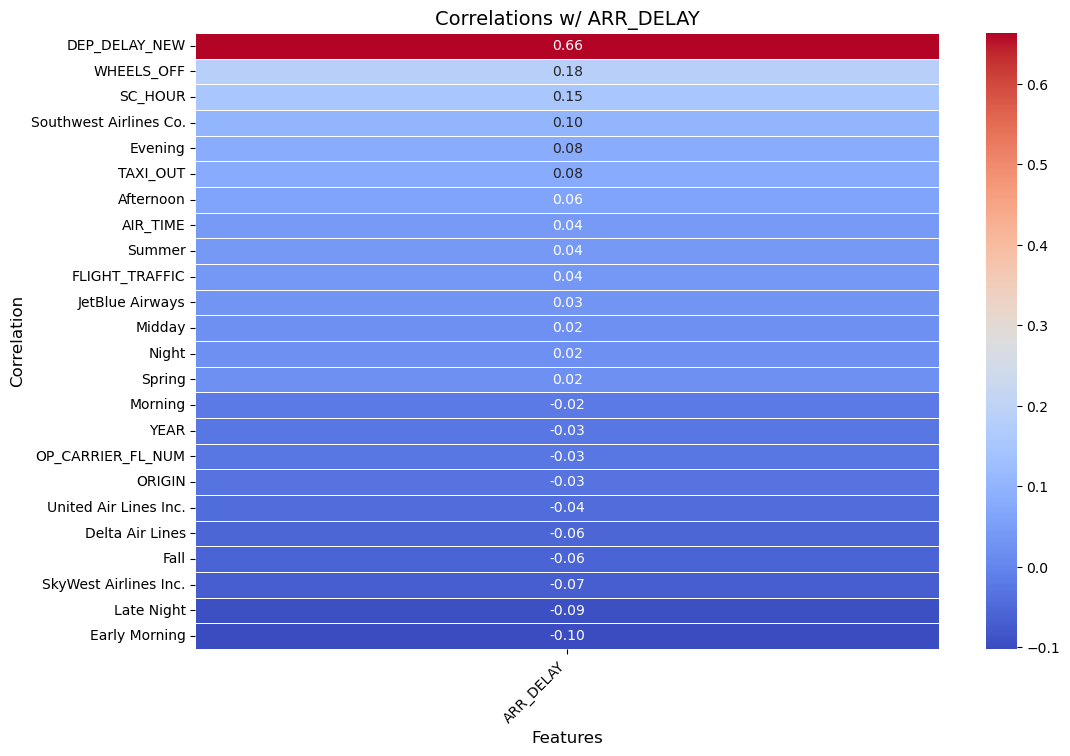

In [36]:
# Spearman Correlation for Non-Linear Relationships
# Step 1: Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(flights_clean_df)

# Step 2: Create a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=flights_clean_df.columns)

# Step 3: Compute the correlation matrix
spearman_corr = scaled_df.corr(method='spearman')

# Step 5: Filter the correlations to show only those involving ARR_DELAY
arr_delay_corr = spearman_corr[['ARR_DELAY']]

# Step 6: Flatten the DataFrame to a Series to avoid shape inconsistency
arr_delay_corr_series = arr_delay_corr['ARR_DELAY']

# Step 7: Filter to show only values between 0.02 and 0.80 or less than -0.02
filtered_arr_delay_corr = arr_delay_corr_series[
    ((arr_delay_corr_series > 0.02) & (arr_delay_corr_series < 0.80)) | (arr_delay_corr_series < -0.02)
]

# Step 8: Sort correlations from greatest to least
sorted_arr_delay_corr = filtered_arr_delay_corr.sort_values(ascending=False)

# Display the filtered and sorted correlations with ARR_DELAY
print("Correlations with ARR_DELAY between 0.02 & 0.80 or less than -0.02 (sorted):")
print(sorted_arr_delay_corr)

# Plot the correlation with ARR_DELAY
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_arr_delay_corr.to_frame(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set the title and labels for better readability
plt.title("Correlations w/ ARR_DELAY", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotate feature names to ensure they're readable
plt.xticks(rotation=45, ha="right", fontsize=10)

# Save the heatmap as a PNG file
plt.savefig("Resources/arr_delay_correlation_sorted.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


### Split the Data and Apply Scaling

In [37]:
# Define features and target
y = flights_clean_df["ARR_DELAY"].values
X = flights_clean_df.drop(columns=["ARR_DELAY"])
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2, stratify=y
)


In [38]:
input_dim = int(X_train.shape[1])

print("Input Dimension:", input_dim)

Input Dimension: 40


In [39]:
# Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  



### Random Forest Model

In [40]:
# Compute the class weights manually
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf = RandomForestClassifier(random_state=78, 
                            class_weight=class_weight_dict,
                            n_estimators=50,
                            oob_score=True,
                            warm_start=True)


rf.fit(X_train_scaled, y_train)


# Make predictions using the best model
y_pred = rf.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the OOB score to see how well the model generalizes
print("OOB Score: {:.4f}".format(rf.oob_score_))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     38603
           1       0.91      0.77      0.84     22123

    accuracy                           0.89     60726
   macro avg       0.90      0.86      0.88     60726
weighted avg       0.89      0.89      0.89     60726

OOB Score: 0.8850


#### Modify number of trees in the model to see if there is an improvement in the results
- Tried 100 and 200 trees and we did not see performance improvement. 50 seems to be the best for Random Forest Model

In [41]:
# Compute the class weights manually
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf_200 = RandomForestClassifier(random_state=78, 
                            class_weight=class_weight_dict,
                            n_estimators=200,
                            oob_score=True,
                            warm_start=True)


rf_200.fit(X_train_scaled, y_train)


# Make predictions using the best model
y_pred = rf_200.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Optionally, print the OOB score to see how well the model generalizes
print("OOB Score: {:.4f}".format(rf_200.oob_score_))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     38603
           1       0.91      0.78      0.84     22123

    accuracy                           0.89     60726
   macro avg       0.90      0.87      0.88     60726
weighted avg       0.89      0.89      0.89     60726

OOB Score: 0.8897


In [42]:
# Get the feature importance from the trained model
importances = rf.feature_importances_

# Create a DataFrame with feature names and their corresponding importance
feature_names = X_train.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get top 10 features based on importance
top_features = feature_importance_df.head(15)
print(top_features)

# Export feature importance to CSV
feature_importance_df.to_csv("Resources/feature_importance.csv", index=False)


                   Feature  Importance
9            DEP_DELAY_NEW    0.413088
8                 TAXI_OUT    0.091925
12                AIR_TIME    0.081156
14              WHEELS_OFF    0.075220
2             DAY_OF_MONTH    0.042801
10          FLIGHT_TRAFFIC    0.039973
11       OP_CARRIER_FL_NUM    0.037384
4                 DISTANCE    0.030610
3              DAY_OF_WEEK    0.027237
13                 SC_HOUR    0.024173
1                    MONTH    0.023254
7                     DEST    0.022430
6           DEST_STATE_ABR    0.016744
0                     YEAR    0.014422
33  Southwest Airlines Co.    0.008442


/var/folders/_5/5t61fvv54s7gmjw6xym9z_7c0000gn/T/ipykernel_9023/2104613836.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = colors = plt.cm.get_cmap("tab20", len(top_20_features))  # "tab20" is a colormap with 20 colors


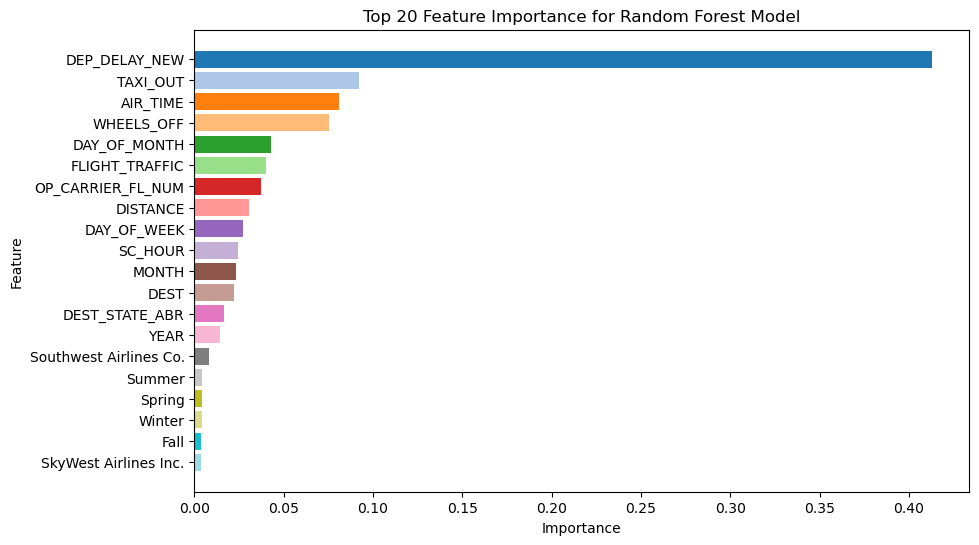

In [43]:
# Plot Feature Importance
# Select the top 20 features based on importance
top_20_features = feature_importance_df.head(20)

# Generate a list of colors using a colormap
colors = colors = plt.cm.get_cmap("tab20", len(top_20_features))  # "tab20" is a colormap with 20 colors

# Plot feature importance with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.barh(top_20_features['Feature'], top_20_features['Importance'], 
                color=colors(np.arange(len(top_20_features))))  # Apply colormap

# Set the labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()  # Reverse the y-axis to show the highest importance at the top

#Save the chart
plt.savefig('Resources/feature_importance.png')

# Display the plot
plt.show()

In [44]:
# Filter features with importance > 0.01
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature'].tolist()

print("Selected Features with Importance > 0.01:", selected_features)

# Use only selected features
X_filtered = flights_clean_df[selected_features]
y_filtered = flights_clean_df["ARR_DELAY"]

# Split filtered data into train and test sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.1, random_state=2, stratify=y
)

# Apply StandardScaler to filtered features
scaler = StandardScaler()
X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)


# Compute the class weights manually
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_filtered), y=y_train_filtered)
class_weight_dict = dict(zip(np.unique(y_train_filtered), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf_filtered = RandomForestClassifier(random_state=78, 
                            class_weight=class_weight_dict,
                            n_estimators=50,
                            oob_score=True,
                            warm_start=True)


rf_filtered.fit(X_train_filtered_scaled, y_train_filtered)

y_pred_filtered = rf_filtered.predict(X_test_filtered_scaled)

# Print classification report
print("Classification Report for the model with selected features:")
print(classification_report(y_test_filtered, y_pred_filtered))

print("OOB Score: {:.4f}".format(rf_filtered.oob_score_))

Selected Features with Importance > 0.01: ['DEP_DELAY_NEW', 'TAXI_OUT', 'AIR_TIME', 'WHEELS_OFF', 'DAY_OF_MONTH', 'FLIGHT_TRAFFIC', 'OP_CARRIER_FL_NUM', 'DISTANCE', 'DAY_OF_WEEK', 'SC_HOUR', 'MONTH', 'DEST', 'DEST_STATE_ABR', 'YEAR']
Classification Report for the model with selected features:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     38603
           1       0.91      0.77      0.84     22123

    accuracy                           0.89     60726
   macro avg       0.90      0.86      0.88     60726
weighted avg       0.89      0.89      0.89     60726

OOB Score: 0.8865


In [45]:

# Filter features with importance > 0.04
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.04]['Feature'].tolist()

print("Selected Features with Importance > 0.04:", selected_features)

# Use only selected features
X_filtered = flights_clean_df[selected_features]
y_filtered = flights_clean_df["ARR_DELAY"]

# Split filtered data into train and test sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.1, random_state=2, stratify=y
)

# Apply StandardScaler to filtered features
scaler = StandardScaler()
X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)


# Compute the class weights manually
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_filtered), y=y_train_filtered)
class_weight_dict = dict(zip(np.unique(y_train_filtered), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf_filtered = RandomForestClassifier(random_state=78, 
                            class_weight=class_weight_dict,
                            n_estimators=50,
                            oob_score=True,
                            warm_start=True)


rf_filtered.fit(X_train_filtered_scaled, y_train_filtered)

y_pred_filtered = rf_filtered.predict(X_test_filtered_scaled)

# Print classification report
print("Classification Report for the model with selected features:")
print(classification_report(y_test_filtered, y_pred_filtered))

print("OOB Score: {:.4f}".format(rf_filtered.oob_score_))

Selected Features with Importance > 0.04: ['DEP_DELAY_NEW', 'TAXI_OUT', 'AIR_TIME', 'WHEELS_OFF', 'DAY_OF_MONTH']
Classification Report for the model with selected features:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     38603
           1       0.86      0.73      0.79     22123

    accuracy                           0.86     60726
   macro avg       0.86      0.83      0.84     60726
weighted avg       0.86      0.86      0.86     60726

OOB Score: 0.8588


### Gradient Boosting Model

In [46]:
# Build Gradient Boosting Model
model_gb = GradientBoostingClassifier()
model_gb = model_gb.fit(X_train_scaled, y_train)
y_pred_gb = model_gb.predict(X_test_scaled)


In [47]:
# Print Classification Report
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91     38603
           1       0.90      0.74      0.81     22123

    accuracy                           0.87     60726
   macro avg       0.88      0.84      0.86     60726
weighted avg       0.88      0.87      0.87     60726



### Decision Tree Model

In [48]:
model_dt = tree.DecisionTreeClassifier()
model_dt = model_dt.fit(X_train_scaled, y_train)
y_pred_dt = model_dt.predict(X_test_scaled)

In [49]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
cm_df = pd.DataFrame(
   cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, y_pred_dt)

# Displaying results
print("Decision Model Classifier Report:")
print(classification_report(y_test, y_pred_dt))


Decision Model Classifier Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     38603
           1       0.79      0.80      0.79     22123

    accuracy                           0.85     60726
   macro avg       0.83      0.84      0.84     60726
weighted avg       0.85      0.85      0.85     60726



### K-Neighbors Model

In [50]:
model_kn=KNeighborsClassifier()
model_kn.fit(X_train_scaled, y_train)
y_pred_kn = model_kn.predict(X_test_scaled)

In [51]:
print("K-Neighbors Classifier Report:")
print(classification_report(y_test, y_pred_kn))


K-Neighbors Classifier Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     38603
           1       0.74      0.52      0.61     22123

    accuracy                           0.76     60726
   macro avg       0.76      0.71      0.72     60726
weighted avg       0.76      0.76      0.75     60726



### Logistic Regression

In [52]:
# Train logistic regression model
model_log = LogisticRegression(solver='lbfgs', random_state=2)
LogisticRegression(max_iter=200, random_state=2)

model_log.fit(X_train_scaled, y_train)
y_pred_log = model_log.predict(X_test_scaled)
pd.DataFrame({"Prediction": y_pred_log, "Actual": y_test}).head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1
5,0,0
6,0,1
7,1,1
8,1,1
9,1,1


In [53]:
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Classifier Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     38603
           1       0.89      0.75      0.82     22123

    accuracy                           0.88     60726
   macro avg       0.88      0.85      0.86     60726
weighted avg       0.88      0.88      0.88     60726



### Neural Network

In [54]:
# Create a function to choose the best model
def build_model(hp):
    model_nn = Sequential()
    
    # Choose activation function
    activation = hp.Choice('activation', ['relu', 'tanh', 'swish'])

    # L2 regularization strength
    reg_strength = hp.Float('reg_strength', min_value=0.0, max_value=0.1, step=0.01)
    
    # Input Layer + First Hidden Layer
    model_nn.add(Dense(
        units=hp.Int('first_units', min_value=6, max_value=64, step=6),
        activation=activation,
        input_shape=(input_dim,)
    ))
    
    # Hidden Layers (1 to 6 layers with variable neurons)
    for i in range(hp.Int('num_layers', 1, 6)):  
        model_nn.add(Dense(
            units=hp.Int('units_' + str(i), min_value=8, max_value=128, step=8),
            activation=activation, 
            kernel_initializer='he_normal'
        ))
        if hp.Boolean('use_dropout'):
            model_nn.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Output Layer (Binary Classification)
    model_nn.add(Dense(units=1, activation="sigmoid"))  
    

    # Compile the model inside the function
    model_nn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model_nn

In [55]:
# Initialize Keras Tuner - Hyperband Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,  
    factor=3,  # Reduction factor for bracketed training
    directory='Resources/models/nn/kt_results',
    project_name='model_opt'
)

# Early stopping to prevent overfitting during search
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    X_train_scaled, y_train,
    epochs=50,  # Ensure this aligns with final training epochs
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    callbacks=[early_stop]
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print Best Hyperparameters
print("\nBest Hyperparameters Found:")
for key in best_hp.values.keys():  # Corrected iteration
    print(f"{key}: {best_hp.get(key)}")  


Reloading Tuner from Resources/models/nn/kt_results/model_opt/tuner0.json

Best Hyperparameters Found:
activation: swish
reg_strength: 0.09
first_units: 60
num_layers: 2
units_0: 80
use_dropout: False
learning_rate: 0.001
dropout_0: 0.1
units_1: 48
dropout_1: 0.4
units_2: 72
dropout_2: 0.4
units_3: 16
units_4: 88
dropout_3: 0.4
units_5: 80
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022


In [57]:
# Build the model with best hyperparameters
best_model = build_model(best_hp) if callable(build_model) else None


if best_model:
    # Train the best model on the full dataset
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    history = best_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50,  # Keeping consistent with hyperparameter tuning
        initial_epoch=4,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )
else:
    print("Error: `build_model` function is not callable. Check its implementation.")

/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 5/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.8655 - loss: 0.3193 - val_accuracy: 0.8901 - val_loss: 0.2665
Epoch 6/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8948 - loss: 0.2584 - val_accuracy: 0.8995 - val_loss: 0.2472
Epoch 7/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8998 - loss: 0.2467 - val_accuracy: 0.9025 - val_loss: 0.2408
Epoch 8/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9026 - loss: 0.2398 - val_accuracy: 0.9049 - val_loss: 0.2338
Epoch 9/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9057 - loss: 0.2334 - val_accuracy: 0.9078 - val_loss: 0.2290
Epoch 10/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9073 - loss: 0.2298 - val_accuracy: 0.9079 - val_loss: 0.2267
Epoch 11/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9085 - loss: 0.2274 - val_accuracy: 0.9074 - val_loss: 0.2282
Epoch 12/50
17079/17079 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accurac

In [58]:
loss, accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

1898/1898 - 2s - 1ms/step - accuracy: 0.9132 - loss: 0.2180
Test Accuracy: 0.9132
Test Loss: 0.2180


In [59]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


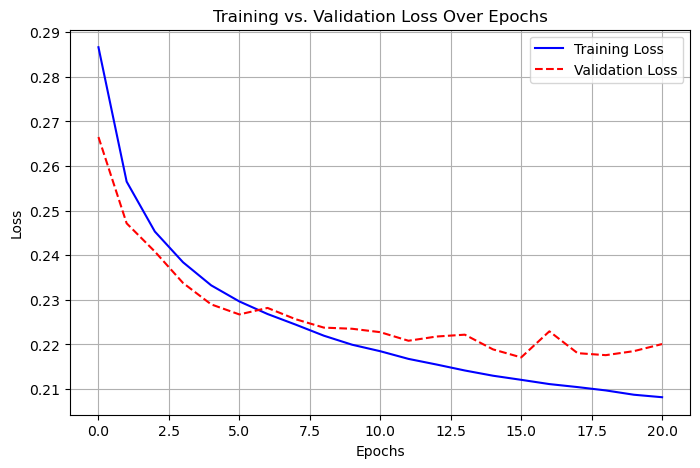

In [60]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss vs. epochs
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", color='blue', linestyle='-')
plt.plot(val_loss, label="Validation Loss", color='red', linestyle='--')

# Labels & Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

#Save the chart
plt.savefig('Resources/train_val_loss.png')

# Show the plot
plt.show()

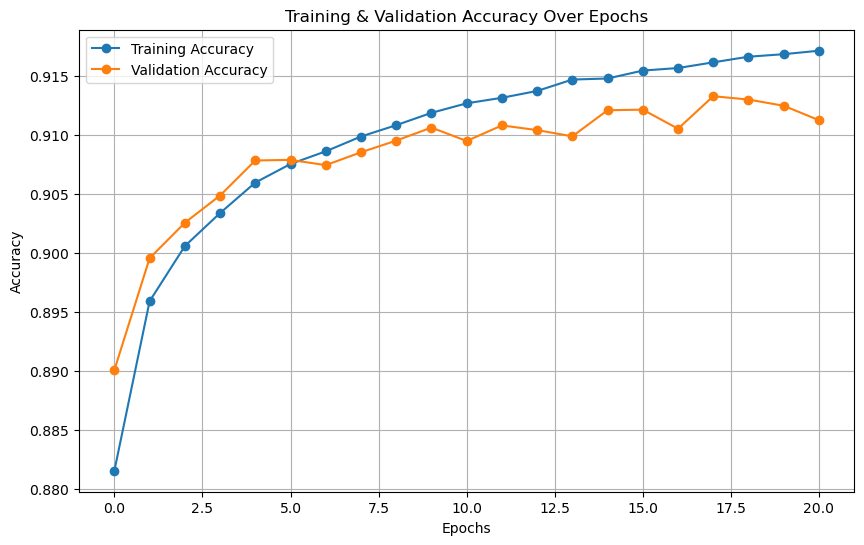

In [61]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("Resources/training_validation_accuracy.png")

# Show the plot
plt.show()

#### Optimization ==> SMOTE

In [62]:
# Apply SMOTE to balance the classes in training data

# Define features and target
y = flights_clean_df["ARR_DELAY"].values
X = flights_clean_df.drop(columns=["ARR_DELAY"])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2, stratify=y
)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Print class distribution after SMOTE
from collections import Counter
print("Before SMOTE:", Counter(y_train))  # Class distribution before resampling
print("After SMOTE:", Counter(y_train_resampled))  # Class distribution after resampling

Before SMOTE: Counter({0: 347426, 1: 199100})
After SMOTE: Counter({0: 347426, 1: 347426})


### Random Forest Model After SMOTE

In [63]:
# Compute the class weights manually (after SMOTE)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf_smote = RandomForestClassifier(
    random_state=78, 
    class_weight=class_weight_dict,
    n_estimators=50,
    oob_score=True,
    warm_start=True
)

# Train the model
rf_smote.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred = rf_smote.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the OOB score
print("OOB Score: {:.4f}".format(rf_smote.oob_score_))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     38603
           1       0.87      0.81      0.84     22123

    accuracy                           0.89     60726
   macro avg       0.88      0.87      0.88     60726
weighted avg       0.89      0.89      0.89     60726

OOB Score: 0.9087


In [64]:
# Hyperparameter Tuning

# Compute the class weights manually (after SMOTE)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

# Define the hyperparameter grid (excluding n_estimators)
param_dist = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest with n_estimators fixed at 50
rf_hp = RandomForestClassifier(
    n_estimators=50,  # Fixed value
    random_state=78,
    class_weight=class_weight_dict,
    oob_score=True,  # Ensure this is set to True for OOB score calculation
    warm_start=False  # Disable warm_start for hyperparameter tuning
)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=rf_hp,
    param_distributions=param_dist,
    n_iter=50,  # Number of different combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available processors
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model from the search
best_rf = random_search.best_estimator_

# Evaluate the best model
y_pred = best_rf.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("OOB Score: {:.4f}".format(best_rf.oob_score_))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   3.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time= 3.0min


/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time= 3.1min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   3.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time= 3.1min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   3.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time= 3.1min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 4.7min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 4.3mi

/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
125 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    raise ValueE

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=5; total time= 4.2min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10; total time= 4.1min
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5; total time= 3.9min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10; total time= 4.0min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 2.4min
Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     38603
           1       0.87      0.81      0.84     22123

    accuracy                           0.89     60726
   macro avg       0.88      0.87      0.88     60726
weighted avg       0.89      0.89      0.89     60726

OOB Score: 0.9087


## Run RandomForest Based on Spearman Correlation Results

In [78]:
flights_clean_filtered = flights_clean_df.copy()
flights_clean_filtered

,ARR_DELAY,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DISTANCE,ORIGIN,DEST_STATE_ABR,DEST,TAXI_OUT,...,JetBlue Airways,Mesa Airlines Inc.,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,United Air Lines Inc.,Fall,Spring,Summer,Winter
0,1,2024,5,1,3,813.0,4,35,32,16.0,...,0,0,0,0,0,0,0,1,0,0
1,1,2024,5,1,3,1773.0,2,22,25,25.0,...,0,0,0,0,0,0,0,1,0,0
2,1,2024,5,1,3,1264.0,2,34,76,19.0,...,0,0,0,0,0,0,0,1,0,0
3,0,2024,5,1,3,868.0,2,35,32,20.0,...,0,0,0,0,0,0,0,1,0,0
4,1,2024,5,1,3,1972.0,2,6,79,13.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607247,0,2024,10,31,4,602.0,2,5,31,7.0,...,0,0,0,1,0,0,1,0,0,0
607248,0,2024,10,31,4,602.0,2,5,31,17.0,...,0,0,0,1,0,0,1,0,0,0
607249,0,2024,10,31,4,843.0,2,35,113,10.0,...,0,0,0,1,0,0,1,0,0,0
607250,0,2024,10,31,4,1037.0,2,24,93,12.0,...,0,0,0,1,0,0,1,0,0,0


In [84]:
# Based on Spearman Correlation >= |0.03|
columns_clean = ["ARR_DELAY", "DEP_DELAY_NEW", "WHEELS_OFF", "SC_HOUR", "Southwest Airlines Co.", "Evening", "TAXI_OUT", 
                 "Afternoon", "AIR_TIME", "Summer", "FLIGHT_TRAFFIC", "JetBlue Airways", 
                 "YEAR", "OP_CARRIER_FL_NUM", "ORIGIN",
                 "United Air Lines Inc.","Fall", "Delta Air Lines", "SkyWest Airlines Inc.",
                 "Late Night", "Early Morning"
                 ]

flights_clean_filtered = flights_clean_filtered[columns_clean]
flights_clean_filtered.head()

,ARR_DELAY,DEP_DELAY_NEW,WHEELS_OFF,SC_HOUR,Southwest Airlines Co.,Evening,TAXI_OUT,Afternoon,AIR_TIME,Summer,...,JetBlue Airways,YEAR,OP_CARRIER_FL_NUM,ORIGIN,United Air Lines Inc.,Fall,Delta Air Lines,SkyWest Airlines Inc.,Late Night,Early Morning
0,1,4,635.0,6.0,0,0,16.0,0,102.0,0,...,0,2024,1025,4,0,0,0,0,0,1
1,1,0,908.0,8.0,0,0,25.0,0,217.0,0,...,0,2024,1093,2,0,0,0,0,0,1
2,1,67,2016.0,18.0,0,1,19.0,0,159.0,0,...,0,2024,1110,2,0,0,0,0,0,0
3,0,0,614.0,5.0,0,0,20.0,0,111.0,0,...,0,2024,1112,2,0,0,0,0,1,0
4,1,9,1306.0,12.0,0,0,13.0,0,226.0,0,...,0,2024,1147,2,0,0,0,0,0,0


### Split data and Scale

In [80]:
# Define features and target
y = flights_clean_filtered["ARR_DELAY"].values
X = flights_clean_filtered.drop(columns=["ARR_DELAY"])
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2, stratify=y
)

In [81]:
# Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

In [82]:
input_dim = int(X_train.shape[1])
input_dim

20

### Random Forest Model

In [83]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights manually
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf = RandomForestClassifier(random_state=78, 
                            class_weight=class_weight_dict,
                            n_estimators=50,
                            oob_score=True,
                            warm_start=True)


rf.fit(X_train_scaled, y_train)


# Make predictions using the best model
y_pred = rf.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optionally, print the OOB score to see how well the model generalizes
print("OOB Score: {:.4f}".format(rf.oob_score_))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     38603
           1       0.89      0.76      0.82     22123

    accuracy                           0.88     60726
   macro avg       0.88      0.85      0.86     60726
weighted avg       0.88      0.88      0.88     60726

OOB Score: 0.8747


## BEST MODEL: RANDOM FOREST MODEL AFTER SMOTE and Hyperparameter Tuning
### Key Statistics
- Accuracy score: Model accurately classifies 89% of flights.
- Out of Bag (OOB) Score: 91% indicates how well model generalizes the unseen data.
- Precision: When predicting flight status:
    - On-time flights: Correct 89% of the time
    - Delayed flights: Correct 87% of the time
- Recall: The model successfully identifies:
    - 93% of actual on-time flights
    - 81% of actual delayed flights

### SUMMARY
- SMOTE sampling balances the dataset by synthetically generating minority class samples.
- Scaling after SMOTE prevents data leakage.
- Class weights updated after SMOTE to ensure balanced weighting during training.
- OOB (Out-of-bag) Score evaluates how well the model generalizes.


In [77]:
# BEST MODEL: Random Forest Model After SMOTE with Optimized Hyperparameters

# Define features and target
y = flights_clean_df["ARR_DELAY"].values
X = flights_clean_df.drop(columns=["ARR_DELAY"])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2, stratify=y
)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Compute the class weights manually (after SMOTE)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

# Initialize the Random Forest Model with OOB enabled
rf_smote = RandomForestClassifier(
    random_state=78, 
    class_weight=class_weight_dict,
    n_estimators=50,
    oob_score=True,
    warm_start=True
)

# Train the model
rf_smote.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred = rf_smote.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the OOB score
print("OOB Score: {:.4f}".format(rf_smote.oob_score_))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     38603
           1       0.87      0.81      0.84     22123

    accuracy                           0.89     60726
   macro avg       0.88      0.87      0.88     60726
weighted avg       0.89      0.89      0.89     60726

OOB Score: 0.9087
